Here I am going to find correlation between number of mutual peptides and JS distance of VJ genes of interacting TCRs

# Imports

In [119]:
%matplotlib inline

import os
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
from scipy import stats

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import warnings
warnings.filterwarnings('ignore')

## Some explaratory analysis of metadata

In [2]:
mdata = pd.read_csv("data/hla-overlap/metadata.txt", sep='\t') # Reading the metadata

In [3]:
mdata.shape

(786, 6)

In [4]:
mdata.head()

,sample_id,age,race,sex,cmv,hla
0,HIP08653,52.0,"caucasian,non-hispanic or latino",female,+,"A*01,A*02,B*07,B*08"
1,HIP13276,53.0,"caucasian,non-hispanic or latino",male,-,"A*01,A*02,B*07,B*08"
2,HIP14114,57.0,"caucasian,non-hispanic or latino",female,-,"A*01,A*02,B*07,B*15"
3,HIP03370,41.0,"caucasian,non-hispanic or latino",male,+,"A*01,A*02,B*07,B*52"
4,HIP13015,39.0,"caucasian,non-hispanic or latino",male,-,"A*01,A*02,B*07,B*57"


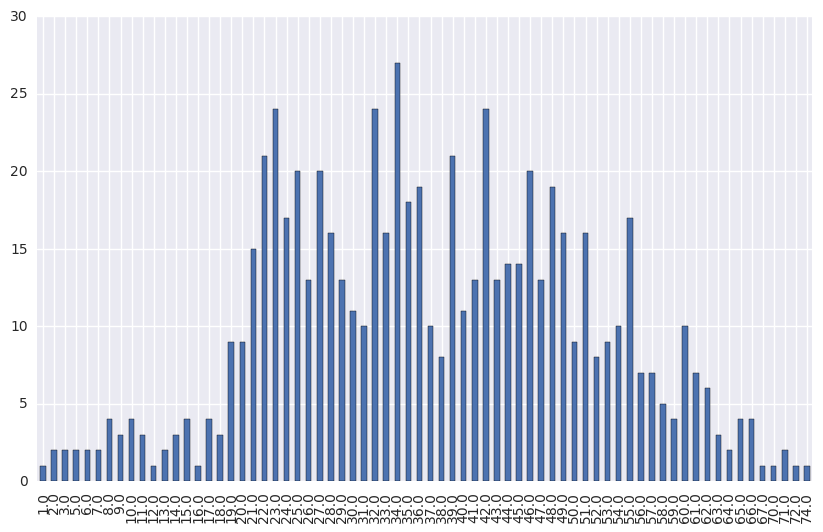

In [5]:
fig = plt.figure(figsize=(10,6))
mdata.age.value_counts(sort=False).plot(kind='bar')

In [6]:
mdata.race.value_counts()

caucasian,non-hispanic or latino                    462
asian or pacific islander,non-hispanic or latino     46
hispanic or latino                                   26
black or african american,non-hispanic or latino     11
non-hispanic or latino                               10
caucasian,hispanic or latino                          3
asian or pacific islander,hispanic or latino          1
black or african american,hispanic or latino          1
Name: race, dtype: int64

In [7]:
mdata.sex.value_counts()

male      392
female    370
Name: sex, dtype: int64

In [8]:
mdata.cmv.value_counts()

-    421
+    340
Name: cmv, dtype: int64

In [9]:
hla = mdata.hla.str.split(',', expand=True)
uhla = pd.unique(hla[[0,1,2,3]].values.ravel('K'))
uhla

array(['A*01', 'A*02', 'A*03', 'A*11', 'A*23', 'A*24', 'A*25', 'A*26',
       'A*29', 'A*30', 'A*31', 'A*32', 'A*33', 'A*68', nan, 'A*34', 'A*66',
       'A*80', 'A*28', 'A*74', 'A*36', 'A*69', None, 'B*07', 'B*08',
       'B*13', 'B*14', 'B*18', 'B*27', 'B*35', 'B*37', 'B*39', 'B*44',
       'B*51', 'B*57', 'B*15', 'B*49', 'B*56', 'B*17', 'B*40', 'B*53',
       'B*38', 'B*45', 'B*60', 'B*41', 'B*05', 'B*62', 'B*50', 'B*55',
       'B*48', 'B*58', 'B*78', 'B*52', 'B*61', 'B*70', 'B*63', 'B*73',
       'B*22', 'B*47', 'B*54', 'B*42', 'B*75', 'B*82'], dtype=object)

In [10]:
arg = pd.read_csv('bash_code/arguments.txt', header=None)
arg.head()

,0
0,HLA-B27:05
1,HLA-B27:20
2,HLA-A01:01
3,HLA-A02:01
4,HLA-A02:02


In [11]:
uhla = pd.DataFrame(uhla, index=range(len(uhla)), columns=[1])
uhla.head()

,1
0,A*01
1,A*02
2,A*03
3,A*11
4,A*23


In [12]:
uhla = uhla.apply(lambda x: 'HLA-' + x + ':01')
uhla[1] = uhla[1].str.replace("*", "")
uhla.head()

,1
0,HLA-A01:01
1,HLA-A02:01
2,HLA-A03:01
3,HLA-A11:01
4,HLA-A23:01


In [13]:
for i in set(uhla[1]) - set(arg[0]):
    print(i)

nan
HLA-B17:01
HLA-B62:01
HLA-B75:01
HLA-B05:01
HLA-A24:01
HLA-B27:01
HLA-B60:01
HLA-B52:01
HLA-B13:01
HLA-B70:01
HLA-B50:01
HLA-B49:01
HLA-B07:01
HLA-B37:01
HLA-A34:01
HLA-B82:01
HLA-A28:01
HLA-B55:01
HLA-B61:01
HLA-B22:01
HLA-B78:01
HLA-B56:01
HLA-A29:01
HLA-B41:01
HLA-B63:01
HLA-B47:01
HLA-B44:01
HLA-A36:01
HLA-B14:01
HLA-A74:01


In [14]:
print(os.getcwd())

/home/vcvetkov/Projects/ipred


## Checking which alleles were not predicted correctly with netMHCpan

In [15]:
alleleslist = []
emptyalleles = []

for file in os.listdir('output/netMHCpan/'):
    if os.stat('output/netMHCpan/' + file).st_size == 0:
        emptyalleles.append(os.path.basename('output/netMHCpan/' + file))
    else:
        alleleslist.append(os.path.basename('output/netMHCpan/' + file))

In [ ]:
alleleslist

In [17]:
emptyalleles = [i.split('_')[0] for i in emptyalleles]
emptyalleles

['HLA-B62:01',
 'HLA-B75:01',
 'HLA-B63:01',
 'HLA-B05:01',
 'HLA-A28:01',
 'HLA-B22:01',
 'HLA-B60:01',
 'HLA-B17:01',
 'HLA-B44:01',
 'HLA-B70:01',
 'HLA-B61:01',
 'HLA-B07:01',
 'HLA-A24:01']

In [18]:
missingalleles = []
import math
for k, i in enumerate(set(uhla[1]) - set(arg[0]) - set(emptyalleles)):
    if k > 0:
        missingalleles.append(i[4] + '*' + i[5:7])
missingalleles

['A*36',
 'B*55',
 'B*13',
 'B*14',
 'B*50',
 'B*78',
 'B*49',
 'B*37',
 'B*27',
 'B*56',
 'A*34',
 'B*82',
 'B*52',
 'B*41',
 'A*29',
 'A*74',
 'B*47']

## DataFrame contains lot's of missing data

In [19]:
mdata.isnull().sum(axis=0)

sample_id      0
age          111
race         226
sex           24
cmv           25
hla          160
dtype: int64

In [20]:
mdata = mdata[mdata.hla.notnull()]

In [21]:
mdata.isnull().sum(axis=0)

sample_id      0
age          108
race         212
sex           24
cmv           25
hla            0
dtype: int64

## There are few individuals not having incorrectly predicted alleles

In [22]:
mdata[~mdata.hla.str.contains('|'.join(missingalleles))].shape

(386, 6)

In [23]:
cdata = mdata[~mdata.hla.str.contains('|'.join(missingalleles))]
cdata.shape

(386, 6)

In [24]:
alleles = []
for i in alleleslist:
    alleles.append(i[4] + '*' + i[5:7])
len(alleles)

99

In [25]:
cdata[cdata.hla.str.contains('|'.join(alleles))].shape

(386, 6)

In [26]:
sum([True if i[8:10] == "01" else False for i in alleleslist])

54

In [27]:
alleles01 = []
for i in alleleslist:
    if i[8:10] == "01":
        alleles01.append(i[4] + '*' + i[5:7])
len(alleles01)

54

In [28]:
alleles_pro_list_df = cdata['hla'].str.split(',', expand = True)
alleles_pre_list_df = alleles_pro_list_df[0]
for i in range(1, 3):
    df = alleles_pro_list_df[i]
    alleles_pre_list_df = pd.concat([alleles_pre_list_df, df])
ds_alleles = alleles_pre_list_df.drop_duplicates().tolist()

In [29]:
len(ds_alleles)

35

## Get alleles for which we have 01 predictions (HLA-A01:  _01_  )

In [30]:
sum([True if i in alleles01 else False for i in ds_alleles])

27

In [31]:
incorrect_alleles = sorted(list(set(ds_alleles)-set(alleles01)))

In [60]:
correct_alleles = sorted(list(set(ds_alleles)&set(alleles01)))

In [33]:
incorrect_alleles

['A*24', 'A*28', 'B*05', 'B*07', 'B*17', 'B*44', 'B*60', 'B*62']

In [34]:
tdata = mdata[~mdata.hla.str.contains('|'.join(incorrect_alleles))]
tdata.head()

,sample_id,age,race,sex,cmv,hla
6,HIP09041,54.0,"caucasian,non-hispanic or latino",female,-,"A*01,A*02,B*08,B*08"
7,HIP13961,NaN,NaN,NaN,NaN,"A*01,A*02,B*08,B*15"
8,HIP17534,55.0,"caucasian,non-hispanic or latino",female,+,"A*01,A*02,B*08,B*15"
9,HIP13956,53.0,"caucasian,non-hispanic or latino",female,+,"A*01,A*02,B*08,B*18"
10,HIP16515,33.0,"caucasian,non-hispanic or latino",male,+,"A*01,A*02,B*08,B*18"


In [113]:
jsd = pd.read_csv("data/hla-overlap/jsd.txt", sep='\t')
jsd.head()

,sample_id_1,sample_id_2,JSD
0,HIP11774,HIP10424,0.018996
1,Keck0080_MC1,HIP10424,0.036506
2,HIP14153,HIP10424,0.020520
3,Keck0081_MC1,HIP10424,0.028761
4,Keck0019_MC1,HIP10424,0.026061


In [114]:
jsd = jsd.drop(jsd[~jsd['sample_id_1'].isin(tdata['sample_id'])].index)
jsd = jsd.drop(jsd[~jsd['sample_id_2'].isin(tdata['sample_id'])].index)
jsd.shape

(26565, 3)

In [37]:
all(jsd['sample_id_1'].isin(tdata['sample_id'])), \
all(jsd['sample_id_2'].isin(tdata['sample_id']))

(True, True)

In [115]:
jsd = jsd.sort_values(by=['sample_id_1', 'sample_id_2'], ascending=[True, True])
jsd.index = range(len(jsd))
jsd.head()

,sample_id_1,sample_id_2,JSD
0,HIP00602,HIP00169,0.022950
1,HIP00728,HIP00169,0.024538
2,HIP00728,HIP00602,0.010451
3,HIP00775,HIP00169,0.038653
4,HIP00775,HIP00602,0.016790


In [39]:
nmp = jsd[['sample_id_1', 'sample_id_2']]
nmp.head()

,sample_id_1,sample_id_2
0,HIP00602,HIP00169
1,HIP00728,HIP00169
2,HIP00728,HIP00602
3,HIP00775,HIP00169
4,HIP00775,HIP00602


In [40]:
tdata = pd.concat([tdata, tdata['hla'].apply(lambda x: pd.Series(str.split(str(x), ',')))], axis=1)
tdata.head()

,sample_id,age,race,sex,cmv,hla,0,1,2,3
6,HIP09041,54.0,"caucasian,non-hispanic or latino",female,-,"A*01,A*02,B*08,B*08",A*01,A*02,B*08,B*08
7,HIP13961,NaN,NaN,NaN,NaN,"A*01,A*02,B*08,B*15",A*01,A*02,B*08,B*15
8,HIP17534,55.0,"caucasian,non-hispanic or latino",female,+,"A*01,A*02,B*08,B*15",A*01,A*02,B*08,B*15
9,HIP13956,53.0,"caucasian,non-hispanic or latino",female,+,"A*01,A*02,B*08,B*18",A*01,A*02,B*08,B*18
10,HIP16515,33.0,"caucasian,non-hispanic or latino",male,+,"A*01,A*02,B*08,B*18",A*01,A*02,B*08,B*18


In [41]:
tdata.isnull().sum(axis=0)

sample_id     0
age          43
race         74
sex          11
cmv          11
hla           0
0             0
1             0
2             0
3             0
dtype: int64

In [42]:
lookup = tdata['sample_id']
for i in range(4):
    ser = tdata[i].apply(lambda x: "HLA-"+x[0]+x[2:4]+':01')
    lookup = pd.concat([lookup, ser], axis=1)
lookup.head()

,sample_id,0,1,2,3
6,HIP09041,HLA-A01:01,HLA-A02:01,HLA-B08:01,HLA-B08:01
7,HIP13961,HLA-A01:01,HLA-A02:01,HLA-B08:01,HLA-B15:01
8,HIP17534,HLA-A01:01,HLA-A02:01,HLA-B08:01,HLA-B15:01
9,HIP13956,HLA-A01:01,HLA-A02:01,HLA-B08:01,HLA-B18:01
10,HIP16515,HLA-A01:01,HLA-A02:01,HLA-B08:01,HLA-B18:01


In [92]:
file_list = ["HLA-"+i[0]+i[2:4]+':01' for i in correct_alleles]

file_dict = {}
for file in tqdm_notebook(alleles01):
    file = 'HLA-' + file[0] + file[2:4] + ':01'
    df = pd.read_csv("output/netMHCpan/" + file + "_NMP_9mer_proc.txt", sep=" ")
    dfb = df[df['Aff(nM)']<=500]
    dfp = dfb.Peptide
    file_dict[file] = dfp

In [ ]:
sorted(file_dict.keys())

In [95]:
def get_pept(sample_id):
    alleles = []
    for i in range(4):
        alleles.append(lookup[lookup['sample_id']==sample_id][i].tolist())
    alleles = [item for sublist in alleles for item in sublist]
    pepdata = []
    counter = []
    try:
        for allele in alleles:
            if allele not in counter:
                pepdata += list(file_dict[allele])
                counter.append(allele)
    except KeyError:
        return []
    return pepdata

from multiprocessing import Pool

def func(data):
    return data.index.map(lambda x: \
                          len(set(get_pept(nmp['sample_id_1'].loc[x]))\
                              &set(get_pept(nmp['sample_id_2'].loc[x]))))

# http://www.racketracer.com/2016/07/06/pandas-in-parallel/

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = list(itertools.chain(pool.map(func, df_split)))
    pool.close()
    pool.join()
    return df

num_partitions = 100 #number of partitions to split dataframe
num_cores = 40 #number of cores on your machine

result = parallelize_dataframe(nmp, func)

In [96]:
result = [item for sublist in result for item in sublist]
len(result)

26565

In [97]:
sum([True if i>0 else False for i in result])

23871

In [116]:
jsd['nmp'] = result
jsd = jsd[jsd['nmp']!=0]
jsd.head()

,sample_id_1,sample_id_2,JSD,nmp
0,HIP00602,HIP00169,0.022950,354193
1,HIP00728,HIP00169,0.024538,340320
2,HIP00728,HIP00602,0.010451,349198
3,HIP00775,HIP00169,0.038653,57665
4,HIP00775,HIP00602,0.016790,60928


In [117]:
print('JS distance var', jsd['JSD'].var(), sep='\t\t\t')
print('Number of mutual peptides var', jsd['nmp'].var(), sep='\t')

JS distance var			0.00016813937204644637
Number of mutual peptides var	21634474037.360947


In [104]:
from scipy.stats import pearsonr

pearsonr(jsd['JSD'], jsd['nmp'])

(0.05584552775777666, 5.8955517655291411e-18)

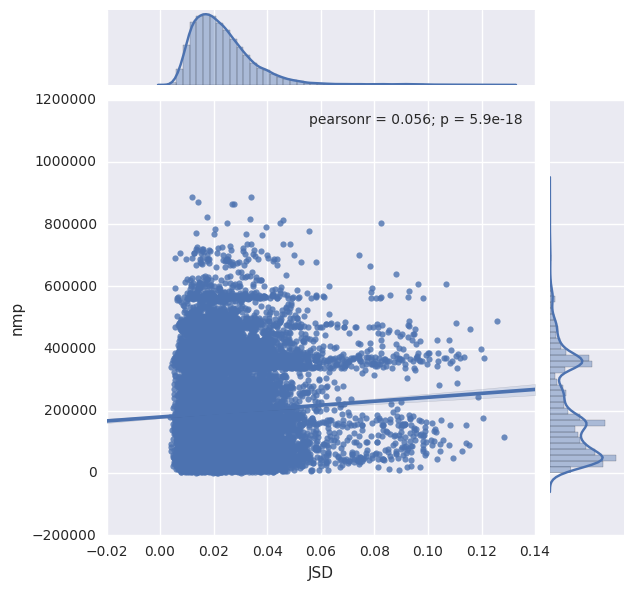

In [120]:
g = sns.jointplot("JSD", "nmp", data=jsd, kind="reg")